# GPR Simulations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
import numpy as np
import healvis as hv
from healvis.data import DATA_PATH
import os
import copy
import healpy as healpy
import hera_pspec as hp
import h5py
from pyuvdata import UVData, UVBeam
from memory_profiler import memory_usage
import glob
from scipy import signal, stats, special, interpolate
from sklearn import gaussian_process as gp
import hera_sim as hs
import uvtools as uvt
import hera_cal as hc
import emcee
from pyhmc import hmc
from scipy import optimize
import corner
import gp_utils
import sim_utils
import pspec_qe as qe
import imp
from astropy import stats as astats

In [11]:
Kf = Kfg.clone_with_theta([np.log(10**2), np.log(2)])(freqs)
Kn = Knoise(freqs)
r = stats.norm.rvs(0,1e-6,Kn.size).reshape(Kn.shape)
f = stats.multivariate_normal.rvs(np.zeros(len(freqs)), Kf, 1000)
n = stats.multivariate_normal.rvs(np.zeros(len(freqs)), Kn, 1000)
y = f + n
invc = np.linalg.pinv(Kf+Kn).dot(y.T)
yp = (Kn).dot(invc).T
r = y - yp
yfft = np.fft.fft(y*uvt.dspec.gen_window('bh7', 128)[None, :], axis=-1)
rfft = np.fft.fft(r*uvt.dspec.gen_window('bh7', 128)[None, :], axis=-1)
nfft = np.fft.fft(n*uvt.dspec.gen_window('bh7', 128)[None, :], axis=-1)


(0, 40)

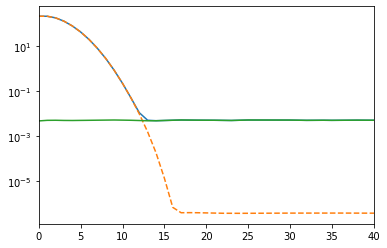

In [13]:
plt.plot(np.mean(np.abs(yfft), axis=0))
plt.plot(np.mean(np.abs(rfft), axis=0), ls='--')
plt.plot(np.mean(np.abs(nfft), axis=0))

plt.yscale('log')
plt.xlim(0, 40)

In [3]:
imp.reload(sim_utils)

<module 'sim_utils' from '/lustre/aoc/projects/hera/nkern/gpr_errs_21cm/notebooks/sim_utils.py'>

In [175]:
# load and setup
bls = [(0, 2), (0, 13), (0, 23), (0, 24), (0, 25)]
reds = [[(0, 2), (0, 13), (0, 25), (0, 24), (0, 23)]]
fgfile1 = '../data/gsm_sim_NSIDE256.uvh5'
fgfile2 = '../data/gleam_sim_NSIDE256.uvh5'
eorfile = '../data/eor_sim_21cmFAST_default_NSIDE256_run2.uvh5'
nfiles = ['../data/noise001_sim.uvh5', '../data/noise002_sim.uvh5']
times = np.arange(0, 4) # np.arange(50) # past 50 and GLEAM drops out
very_low_snr = 1e2
low_snr = 1.5e3
hi_snr = 5e3
D, F, E, N = sim_utils.setup_data([fgfile1, fgfile2], eorfile, nfiles[0],
                                  fg2=[fgfile1, fgfile2], eor2=eorfile, noise2=nfiles[1],
                                  eor_tilt=0, noise_suppress=hi_snr, times=times, bls=bls, combine_reds=reds)

antenna_diameters is not set. Using known values for HERA.


In [5]:
C = hp.conversions.Cosmo_Conversions()
t2k = C.tau_to_kpara(C.f2z(np.mean(D.freqs))) / 1e9

Text(0, 0.5, 'North [meters]')

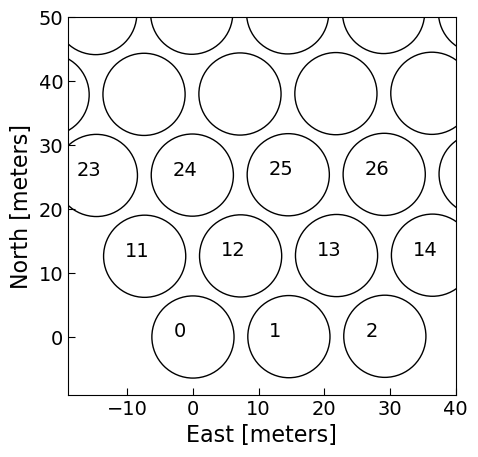

In [9]:
antpos, ants = D.hd.get_ENU_antpos()
antpos -= antpos[np.argmin(ants)]

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax.tick_params(labelsize=14, direction='in', size=5)
ax.scatter(antpos[:, 0], antpos[:, 1], fc='None', ec='k', s=3500)
for i, a in enumerate(ants):
    if a > 26: continue
    ax.text(antpos[i,0]-3,antpos[i,1],a,fontsize=14)
ax.set_xlim(-19, 40)
ax.set_ylim(-9, 50)
ax.set_xlabel('East [meters]', fontsize=16)
ax.set_ylabel('North [meters]', fontsize=16)

In [5]:
# filter to only one or a few modes if desired (i.e. impulse test)
#E.fft_data(data=E.data, window='tophat', overwrite=True)
#filt = np.zeros_like(E.delays)
#filt[(E.delays > 800) & (E.delays < 850)] = 1.0
#for k in E.data:
#    dfft = np.fft.fftshift(np.fft.fft(E.data[k], axis=1), axes=1)
#    E.data[k] = np.fft.ifft(np.fft.ifftshift(dfft * filt, axes=1), axis=1)

In [176]:
# setup parameters for fitting
k = (0, 2, 'xx')
Ntimes, Nfreqs = D.data[k].shape
freqs = D.freqs[:, None] / 1e6

In [177]:
# estimate noise from even-odd difference
nvar = np.std([(D.data[_k][::2] - D.data[_k][1::2]).real/np.sqrt(2) for _k in D.data])**2
print(np.sqrt(nvar))

0.0011254885577887607


In [178]:
# get eor variance
estd = np.std(E.hd.data_array.real)
print(estd)
print(estd / np.sqrt(nvar))

0.0023282637518286455
2.068669410911621


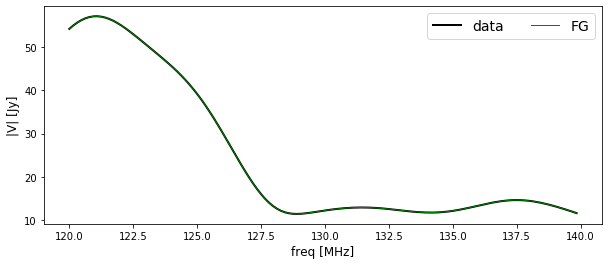

In [179]:
fig, ax = plt.subplots(figsize=(10, 4))
k = (0, 2, 'xx')
ax.plot(D.freqs/1e6, np.abs(D.data[k])[0], label='data', c='k', lw=2)
ax.plot(F.freqs/1e6, np.abs(F.data[k])[0], label='FG', c='green', lw=1)
ax.set_xlabel('freq [MHz]', fontsize=12)
ax.set_ylabel('|V| [Jy]', fontsize=12)
ax.legend(ncol=2, fontsize=14)

In [180]:
# define kernels
Ksky = gp.kernels.ConstantKernel(1, constant_value_bounds=(1e-1, 500)) \
       * gp.kernels.RBF(length_scale=10.0, length_scale_bounds=(10, 50))
Ksky.labels = [r'$\sigma_{\rm sky}$', r'$\ell_{\rm sky}$']

Kmix = gp.kernels.ConstantKernel(1, constant_value_bounds=(1e-2, 250)) \
       * gp.kernels.RBF(length_scale=5.0, length_scale_bounds=(2.5, 10))
#Kmix = gp.kernels.ConstantKernel(1, constant_value_bounds=(1, 100)) \
#       * gp.kernels.Matern(length_scale=1.0, nu=3./2, length_scale_bounds=(5, 10))
Kmix.labels = [r'$\sigma_{\rm mix}$', r'$\ell_{\rm mix}$']

Kfg = Ksky + Kmix
Kfg.labels = Ksky.labels + Kmix.labels

Kr = gp.kernels.ConstantKernel(1, constant_value_bounds=(1e-2, 10)) \
       * gp.kernels.RationalQuadratic(length_scale=5.0, length_scale_bounds=(1, 100),
                                      alpha=1.0, alpha_bounds=(1e-2, 1e2))
Kr.labels = [r'$\sigma_{\rm r}$', r'$\ell_{\rm r}$', r'$\alpha_{\rm r}$']

##########################################################################################

Kfg = gp.kernels.ConstantKernel(1e2, constant_value_bounds=(1e0, 1e6)) \
       * gp.kernels.RBF(length_scale=5.0, length_scale_bounds=(2.0, 50))
Kfg.labels = [r'$\sigma_{\rm fg}$', r'$\ell_{\rm fg}$']

Keor = gp.kernels.ConstantKernel(1e-6, constant_value_bounds=(1e-10, 1)) \
       * gp.kernels.Matern(length_scale=1.0, nu=0.5, length_scale_bounds=(1e-5, 2.0))
Keor.labels = [r'$\sigma_{\rm 21}$', r'$\ell_{\rm 21}$']

Knoise = gp.kernels.WhiteKernel(noise_level=nvar, noise_level_bounds=(nvar, nvar))
Knoise.labels = [r'$\sigma_{\rm N}$']

Kpln = gp.kernels.Product(Knoise, gp_utils.DiagPowerLawKernel(beta=2.0, beta_bounds=(1e0, 2.5), anchorx=120))
Kpln.labels = [r'$\sigma_{\rm N}$', r'$\beta_{\rm N}$']

kdict = dict(Ksky=Ksky, Kmix=Kmix, Kr=Kr, Keor=Keor, Knoise=Knoise, Kpln=Kpln, Kfg=Kfg)

In [15]:
imp.reload(gp_utils)

<module 'gp_utils' from '/lustre/aoc/projects/hera/nkern/gpr_errs_21cm/notebooks/gp_utils.py'>

In [181]:
# setup GP model
optimizer = 'fmin_l_bfgs_b'
n_restarts = 15
norm_y = False
G, Knames, labels, theta_bounds = gp_utils.setup_gp(['Knoise', 'Keor', 'Kfg'], kdict,
                                                    optimizer=optimizer, n_restarts=n_restarts, norm_y=norm_y)

In [182]:
# setup priors
#G.theta_priors = [None, None, gp_utils.gamma(6.0, 5.7), None, None]
G.theta_priors = [None, None, gp_utils.gauss(2.0), None, None]
G.theta_priors = None

In [183]:
# train and predict
theta_chain = {}
theta_ml, F.mdl, F.mdl_cov, E.mdl, E.mdl_cov = gp_utils.gp_fit_predict(D.data, G, freqs,
                                                                       Kfg_name=Knames[-1], Keor_name=Knames[-2])
G.kernel_

invalid value encountered in true_divide
fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.42209327e-02, -5.46412551e-02, -6.10798205e-09,  1.49955739e-02,
       -2.02030642e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 16, 'warnflag': 2}
fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.94599617e+01, -1.22936466e-03,  1.18157373e-02, -2.19132344e-03,
        2.55787540e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 133, 'nit': 36, 'warnflag': 2}
fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.28962041e-05, -1.19615700e-04, -6.24146556e-06,  3.45790887e-03,
       -2.42809653e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 103, 'nit': 24, 'warnflag': 2}
fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-19.39754088,   0.08900509,  -0.05112835,  -0.038083  ,
         0.15008695]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit':

WhiteKernel(noise_level=1.27e-06) + 0.00183**2 * Matern(length_scale=0.158, nu=0.5) + 44.3**2 * RBF(length_scale=4.05)

In [12]:
# select dataset to MCMC
k = (0, 2, 'xx')
_ = G.prep_ydata(freqs, D.data[k].T)

In [20]:
# generate starting pos for emcee chain
nwalkers = 50
theta = np.exp(G.kernel_.theta)
start_vec = theta[1:]
ndims = start_vec.size
offset = stats.norm.rvs(1, 0.1, nwalkers * ndims).reshape(nwalkers, ndims).clip(1e-10)
start_pos = start_vec[None, :] * offset

In [281]:
# run sampler
S = gp_utils.emcee_train(start_pos, G, nstep=500, unlogged=True, theta_bounds=np.exp(theta_bounds),
                         prepend=theta[0])

In [282]:
# eliminate low acceptance fraction chains
good_chains = ~(S.acceptance_fraction < 0.05)
chain = S.chain[good_chains]
chain = chain.reshape(-1, ndims)
theta_chain[k] = chain

In [283]:
# re-normalize 
norm_chain = chain.copy()
norm_chain[:, 0] = np.sqrt(norm_chain[:, 0])
norm_chain[:, 2] = np.sqrt(norm_chain[:, 2])

In [284]:
theta_map = stats.mode(norm_chain, axis=0).mode[0]
theta_sig = np.sqrt(astats.biweight_midvariance(norm_chain, axis=0))
for i, l in enumerate(labels[1:]):
    print("{} MAP : {:.10f} +/- {:.10f}".format(l, theta_map[i], theta_sig[i]))

$\sigma_{\rm 21}$ MAP : 0.0010002961 +/- 0.0007092002
$\ell_{\rm 21}$ MAP : 0.0178897649 +/- 0.6799215848
$\sigma_{\rm fg}$ MAP : 37.6625519456 +/- 7.1623177304
$\ell_{\rm fg}$ MAP : 3.9552021904 +/- 0.1181827454


In [285]:
# divide by sigma_n
norm_chain[:, 0] /= np.sqrt(nvar)
labels[1] += r'$/\sigma_n$'

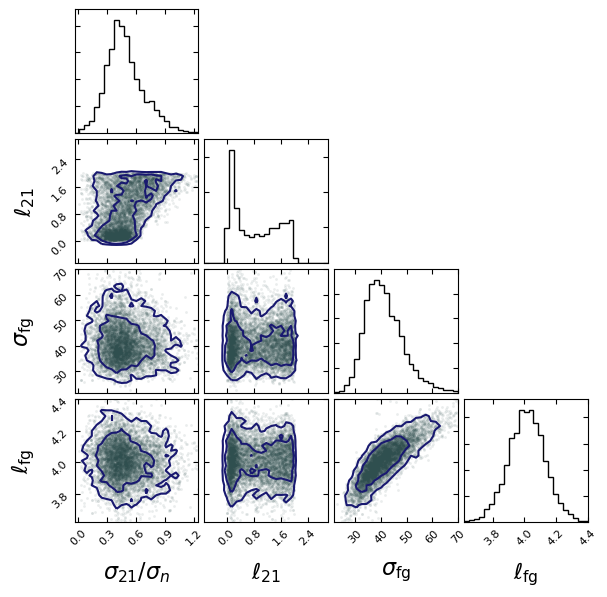

In [286]:
ndims = chain.shape[1]
fig, axes = plt.subplots(ndims, ndims, figsize=(6, 6), dpi=100)
med, std = np.median(norm_chain, axis=0), np.sqrt(astats.biweight_midvariance(norm_chain, axis=0))
ranges = np.array([med-std*3.5, med+std*3.5]).T
ranges = (np.quantile(norm_chain, [.05, .95], axis=0) - np.median(norm_chain, axis=0))*2 + np.median(norm_chain, axis=0)
ranges = ranges.T

_ = corner.corner(norm_chain[::5], fig=fig, bins=25, labels=labels[1:], range=ranges, levels=[0.68, 0.95],
                  plot_density=False, no_fill_contours=True, plot_datapoints=True,
                  data_kwargs={'color':'darkslategrey','alpha':0.1}, contour_kwargs={'colors':'midnightblue'})
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        ax.tick_params(labelsize=8, direction='in', top=True, right=True)
        if j == 0 and i > 0:
            ax.set_ylabel(labels[i+1], fontsize=16, labelpad=10)
        if i == axes.shape[0]-1:
            ax.set_xlabel(labels[j+1], fontsize=16, labelpad=10)

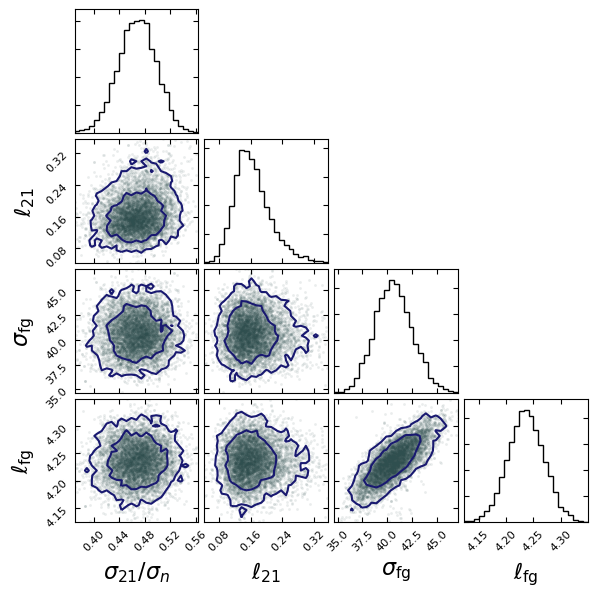

In [258]:
ndims = chain.shape[1]
fig, axes = plt.subplots(ndims, ndims, figsize=(6, 6), dpi=100)
med, std = np.median(norm_chain, axis=0), np.sqrt(astats.biweight_midvariance(norm_chain, axis=0))
ranges = np.array([med-std*3.5, med+std*3.5]).T
ranges = (np.quantile(norm_chain, [.05, .95], axis=0) - np.median(norm_chain, axis=0))*2 + np.median(norm_chain, axis=0)
ranges = ranges.T

_ = corner.corner(norm_chain[::5], fig=fig, bins=25, labels=labels[1:], range=ranges, levels=[0.68, 0.95],
                  plot_density=False, no_fill_contours=True, plot_datapoints=True,
                  data_kwargs={'color':'darkslategrey','alpha':0.1}, contour_kwargs={'colors':'midnightblue'})
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        ax.tick_params(labelsize=8, direction='in', top=True, right=True)
        if j == 0 and i > 0:
            ax.set_ylabel(labels[i+1], fontsize=16, labelpad=10)
        if i == axes.shape[0]-1:
            ax.set_xlabel(labels[j+1], fontsize=16, labelpad=10)

divide by zero encountered in log
divide by zero encountered in log


Text(0.5, 1.0, 'prior on $\\ell_{21}$')

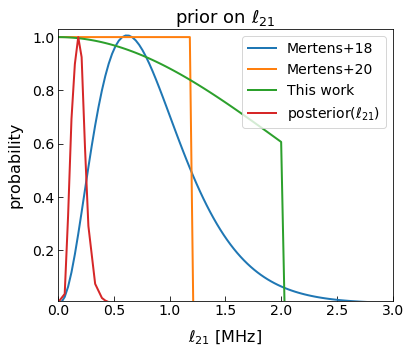

In [1706]:
x = np.linspace(0, 3, 100)
fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(labelsize=14, direction='in', size=5)
ax.plot(x, np.exp(gp_utils.gamma(3.6, 4.2)(x)), lw=2, label=r'Mertens+18')
ax.plot(x, np.exp(gp_utils.uniform(0, 1.2)(x)), lw=2, label=r'Mertens+20')
ax.plot(x, np.exp(gp_utils.gauss(2.)(x)+gp_utils.uniform(0, 2.0)(x)), lw=2, label=r'This work')
p = np.histogram(norm_chain[:, 1], bins=45, range=(0, 3))
p = interpolate.interp1d(p[1][:-1], p[0], kind='linear', fill_value='extrapolate')(x)
ax.plot(x, p/p.max(), lw=2, label=r'${\rm posterior}(\ell_{21})$')
ax.legend(fontsize=14, loc=1)
ax.set_xlim(0, 3)
ax.set_ylim(0.01, 1.03)
ax.set_xlabel(r'$\ell_{21}$ [MHz]', fontsize=16, labelpad=10)
ax.set_ylabel('probability', fontsize=16, labelpad=10)
ax.set_title(r"prior on $\ell_{21}$", fontsize=18)

In [19]:
# take difference with data
D.resid = D.data - F.mdl

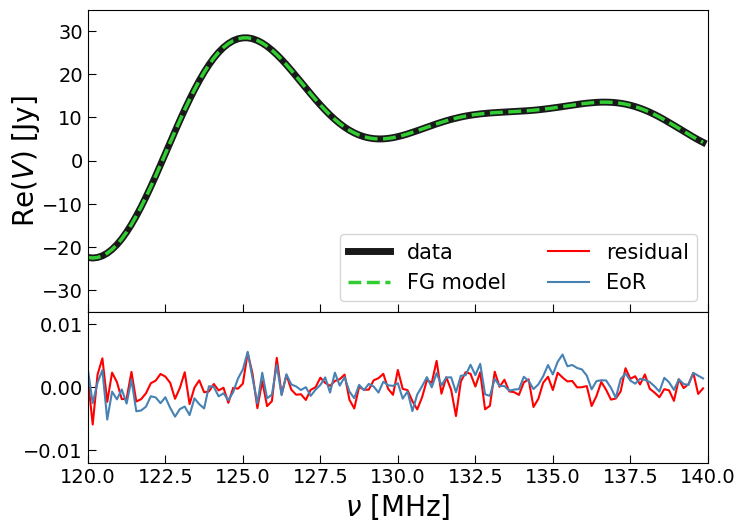

In [20]:
grid = gridspec.GridSpec(nrows=3, ncols=1)
fig = plt.figure(figsize=(8, 6), dpi=100)
fig.subplots_adjust(hspace=0.0)
k = (0, 2, 'xx')
xlim = 120, 140

ax = fig.add_subplot(grid[:2, :])
ax.tick_params(labelsize=14, direction='in', size=6)
ax.plot(D.freqs/1e6, np.real(D.data[k])[0], lw=5, c='k', label='data', alpha=0.9)
ax.plot(D.freqs/1e6, np.real(F.mdl[k])[0], ls='--', lw=2.5, c='limegreen', label='FG model')
#ax.plot(D.freqs/1e6, np.abs(F.data[k])[0], lw=1, c='forestgreen', label='fg data')
ax.set_xlim(xlim)
ax.set_ylim(-35, 35)
ax.set_xticklabels([])
ax.set_ylabel(r"${\rm Re}(V)$ [Jy]", fontsize=20, labelpad=0)

ax2 = fig.add_subplot(grid[2:, :])
ax2.tick_params(labelsize=14, direction='in', size=6)
ax2.plot(D.freqs/1e6, np.real(D.resid[k])[0], c='r', label='data residual', ls='-')
ax2.plot(D.freqs/1e6, np.real(E.data[k])[0], c='steelblue', label='eor data')
ax2.set_xlim(xlim)
ax2.set_ylim(-.012, .012)
ax2.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax.legend(ax.lines+ax2.lines, ['data', 'FG model', 'residual', 'EoR'], ncol=2, fontsize=15, loc=4)

In [42]:
imp.reload(qe)

<module 'pspec_qe' from '/lustre/aoc/projects/hera/nkern/gpr_errs_21cm/notebooks/pspec_qe.py'>

In [22]:
# get noise covariance
N.cov = hc.datacontainer.DataContainer({})
for k in N.data:
    N.cov[k] = np.eye(N.Nfreqs).astype(np.complex) * nvar

In [228]:
e1 = E.data
x1 = F.data + E.data
x2 = None
el = 0
eh = 0
Nfreqs = len(freqs)
Nbls = len(x1)
win = uvt.dspec.gen_window('bh', Nfreqs, edgecut_low=el, edgecut_hi=eh)

In [229]:
beam = hp.PSpecBeamUV('../data/HERA_NF_pstokes_power.beamfits')
scalar = beam.compute_pspec_scalar(freqs[0, 0]*1e6, freqs[-1, 0]*1e6, Nfreqs, taper='bh', exact_norm=False)
exact_scalar = beam.compute_pspec_scalar(freqs[0, 0]*1e6, freqs[-1, 0]*1e6, Nfreqs, taper='bh', exact_norm=True)

# add in Jy2mK
Jy2mK = beam.Jy_to_mK(freqs*1e6).mean()
scalar *= Jy2mK**2
exact_scalar *= Jy2mK**2

# add Opp factor
Op, Opp = beam.get_Omegas([('pI', 'pI')])
find = np.argmin(np.abs(beam.beam_freqs - freqs.mean()*1e6))
exact_scalar /= Opp[find]

In [230]:
I = np.eye(Nfreqs)
T = I * win

In [187]:
r = T @ I

In [231]:
kn = G.kernel_.k1.k1
kf = G.kernel_.k2
ke = G.kernel_.k1.k2

In [394]:
Covf = kf(freqs) - kf(freqs) @ np.linalg.pinv(kf(freqs) + kn(freqs) + ke(freqs)) @ kf(freqs)

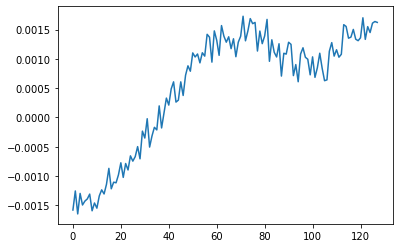

In [396]:
plt.plot(Covf.diagonal())

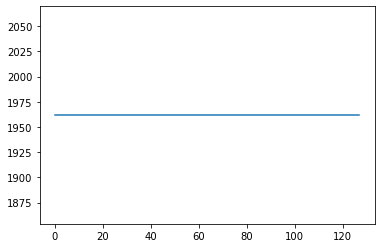

In [398]:
plt.plot(kf(freqs).diagonal())

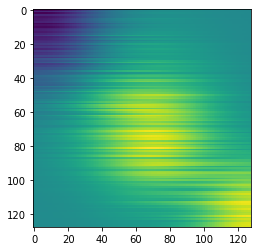

In [397]:
plt.imshow(Covf)

In [232]:
r = T @ (I - kf(freqs) @ np.linalg.pinv(kf(freqs) + ke(freqs) + kn(freqs)))

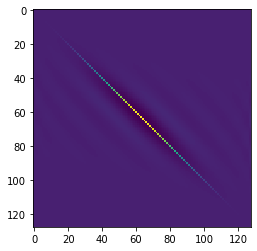

In [214]:
plt.imshow(r.real)

In [246]:
x = x1[k][10]
e = e1[k][10]

In [247]:
xfft = 0.5 * np.fft.ifft(x*win) * np.fft.ifft(x*win).conj()
efft = 0.5 * np.fft.ifft(e*win) * np.fft.ifft(e*win).conj()

In [248]:
Q = np.array([np.fft.ifft(np.eye(Nfreqs), axis=-1)[i] for i in range(Nfreqs)])
Q = np.array([q[None, :].T.conj().dot(q[None, :]) for q in Q])

In [249]:
rx = r.dot(x)

In [250]:
q = 0.5 * np.array([rx.T.conj().dot(q).dot(rx) for q in Q])

In [256]:
H = 0.5 * np.array([[np.trace(r @ Qa @ r @ Qb) for Qb in Q] for Qa in Q])
M = np.eye(Nfreqs) / np.sum(H, axis=-1)

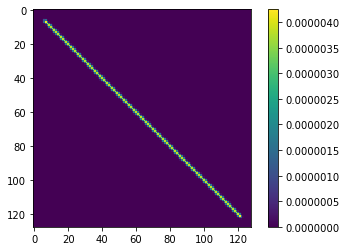

In [261]:
plt.imshow(H.real)
plt.colorbar()

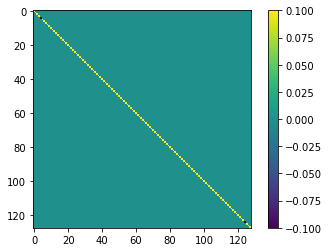

In [101]:
plt.imshow(M.real, vmin=-.1, vmax=.1)
plt.colorbar()

In [252]:
p = M.dot(q)

In [289]:
Q.shape

(128, 128, 128)

In [285]:
Emat = 0.5 * np.array([M[i, i] * r.dot(Q[i]).dot(r) for i in range(Nfreqs)])

b = np.array([np.trace(emat.dot(kf(freqs))) for emat in Emat])

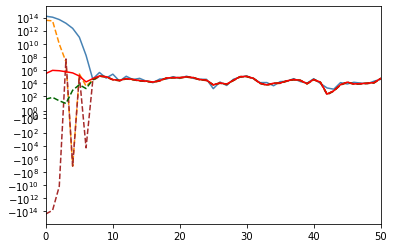

In [284]:
plt.plot(np.abs(xfft) * scalar, color='steelblue')
plt.plot(np.real(p) * exact_scalar * np.sqrt(2), color='darkorange', ls='--')
plt.plot(np.real(p-b) * exact_scalar * np.sqrt(2), color='brown', ls='--')
plt.plot(np.real(q) * scalar, color='darkgreen', ls='--')
plt.plot(np.abs(efft) * scalar, color='r')
plt.xlim(0, 50)
plt.yscale('symlog')

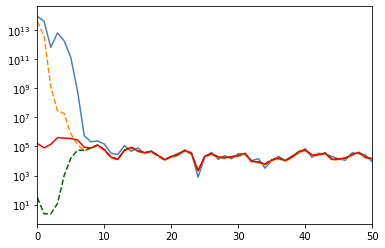

In [244]:
plt.plot(np.abs(xfft) * scalar, color='steelblue')
plt.plot(np.abs(p) * exact_scalar * np.sqrt(2), color='darkorange', ls='--')
plt.plot(np.real(q) * scalar, color='darkgreen', ls='--')
plt.plot(np.abs(efft) * scalar, color='r')
plt.xlim(0, 50)
plt.yscale('log')

In [ ]:
Q = np.array([np.fft.ifft(np.eye(Nfreqs), axis=-1)[i] for i in range(Nfreqs)])
Q = np.array([q[:, None].dot(q[:, None].T.conj()) for q in Q])

In [50]:
r = np.eye(Nfreqs)

In [70]:
H = 0.5 * np.array([[np.trace(r.dot(Qa).dot(r).dot(Qb)) for Qb in Q] for Qa in Q])
M = np.eye(Nfreqs) / np.sum(H, axis=-1)

In [78]:
scalar/1e8

43.53818004316066

In [84]:
M

array([[32768.+0.00000000e+00j,     0.+0.00000000e+00j,
            0.+0.00000000e+00j, ...,     0.+0.00000000e+00j,
            0.+0.00000000e+00j,     0.+0.00000000e+00j],
       [    0.+0.00000000e+00j, 32768.+3.96746202e-13j,
            0.+0.00000000e+00j, ...,     0.+0.00000000e+00j,
            0.+0.00000000e+00j,     0.+0.00000000e+00j],
       [    0.+0.00000000e+00j,     0.+0.00000000e+00j,
        32768.-2.16389589e-13j, ...,     0.+0.00000000e+00j,
            0.+0.00000000e+00j,     0.+0.00000000e+00j],
       ...,
       [    0.+0.00000000e+00j,     0.+0.00000000e+00j,
            0.+0.00000000e+00j, ..., 32768.-7.08153900e-14j,
            0.+0.00000000e+00j,     0.+0.00000000e+00j],
       [    0.+0.00000000e+00j,     0.+0.00000000e+00j,
            0.+0.00000000e+00j, ...,     0.+0.00000000e+00j,
        32768.+1.87891951e-13j,     0.+0.00000000e+00j],
       [    0.+0.00000000e+00j,     0.+0.00000000e+00j,
            0.+0.00000000e+00j, ...,     0.+0.00000000e+00j,
 

In [43]:
# get power spectra
win = 'bh7'
beam = hp.PSpecBeamUV('../data/HERA_NF_pstokes_power.beamfits')
scalar = beam.compute_pspec_scalar(D.freqs[0], D.freqs[-1], Nfreqs, taper=win)
el, eh = 0, 0
cross = True
blavg = False
# divide N.cov by 2 if cross is True (Dillon+14)
D.dpsp, D.pcov, dlys = qe.qe(D.data, D.freqs, window=win, beam=beam, scalar=scalar, el=el, eh=eh,
                             cov=F.mdl_cov+N.cov+E.mdl_cov, cross=cross, blavg=blavg)
F.mpsp, F.pcov, dlys = qe.qe(F.mdl, F.freqs, window=win, beam=scalar, cov=F.mdl_cov, el=el, eh=eh,
                             cross=cross, blavg=blavg)
D.rpsp,      _, dlys = qe.qe(D.resid, D.freqs, window=win, beam=scalar, el=el, eh=eh, cross=cross, blavg=blavg)
E.dpsp,      _, dlys = qe.qe(E.data, E.freqs, window=win, beam=scalar, el=el, eh=eh, cross=cross, blavg=blavg)
E.mpsp, E.pcov, dlys = qe.qe(E.mdl, E.freqs, window=win, beam=scalar, el=el, eh=eh,
                             cross=cross, cov=E.mdl_cov, blavg=blavg)
N.dpsp, N.pcov, dlys = qe.qe(N.data, N.freqs, window=win, beam=scalar, cov=N.cov, el=el, eh=eh,
                             cross=cross, blavg=blavg)

ValueError: shapes (128,128) and (40,128) not aligned: 128 (dim 1) != 40 (dim 0)

In [40]:
beam.get_Omegas([('pI', 'pI')])[0].shape

(26, 1)

Casting complex values to real discards the imaginary part


Text(0.5, 0, '$\\tau$ [ns]')

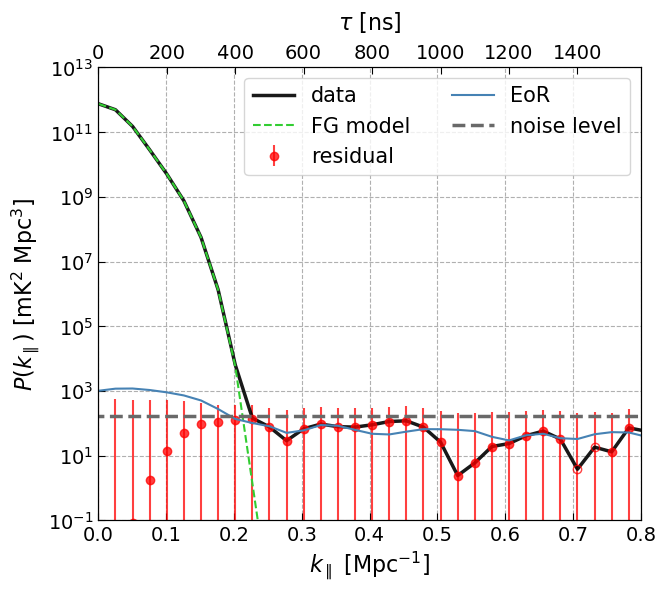

In [25]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
ax.tick_params(labelsize=14, direction='in', size=5)
kpara = dlys * t2k
k = (0, 2, 'xx')

yerr = np.sqrt(D.pcov[k].diagonal())
gp_utils.plot_pspec(kpara, D.dpsp[k][0].real, ax, c='k', label='data', lw=2.5, comp='abs-real', alpha=0.9)
gp_utils.plot_pspec(kpara, F.mpsp[k][0].real, ax, c='limegreen', label='FG model', ls='--', lw=1.5, comp='abs')
gp_utils.plot_pspec(kpara, D.rpsp[k][0].real, ax, c='r', label='residual', ls='', fmt='o', yerr=yerr, alpha=0.75, comp='real')
gp_utils.plot_pspec(kpara, E.dpsp[k][0].real, ax, c='steelblue', label='EoR', lw=1.5, comp='abs-real')
gp_utils.plot_pspec(kpara, np.sqrt(N.pcov[k].diagonal()), ax, c='dimgray', label='noise level', lw=2.5, ls='--')
#gp_utils.plot_pspec(kpara, E.mpsp[k][0].real, ax, c='darkblue', label='EoR Model', lw=1.5, comp='abs-real')
#gp_utils.plot_pspec(kpara, N.dpsp[k][0].real, ax, c='magenta', label='noise', ls='', fmt='o', comp='real')
#ax.annotate(s='', xy=(0.01, 1e0), xytext=(0.01, 1e2), arrowprops=dict(arrowstyle='<|-|>'))
    
ax.set_xlabel(r'$k_\parallel$ [Mpc$^{-1}$]', fontsize=16)
ax.set_ylabel(r'$P(k_\parallel)$ [mK$^2$ Mpc$^{3}$]', fontsize=16)
ax.legend(fontsize=15, ncol=2)
ax.set_yscale('log')
ax.grid(ls='--')
ax.set_xlim(0, .8)
ax.set_ylim(1e-1, 1e13)
ax2 = ax.twiny()
ax2.set_xlim(np.array(ax.get_xlim())/t2k)
ax2.tick_params(labelsize=14, direction='in', size=5)
ax2.set_xlabel(r'$\tau$ [ns]', fontsize=16, labelpad=10)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


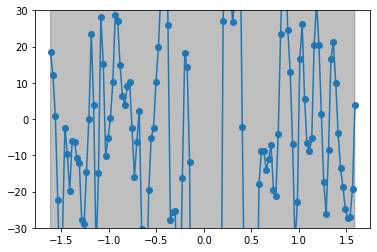

In [1822]:
plt.plot(kpara, D.rpsp[k][0].real-E.dpsp[k][0].real, marker='o')
plt.ylim(-3e1, 3e1)
plt.fill_between(kpara, -yerr, yerr, color='k', alpha=0.25)

Text(0.5, 0, '$\\tau$ [ns]')

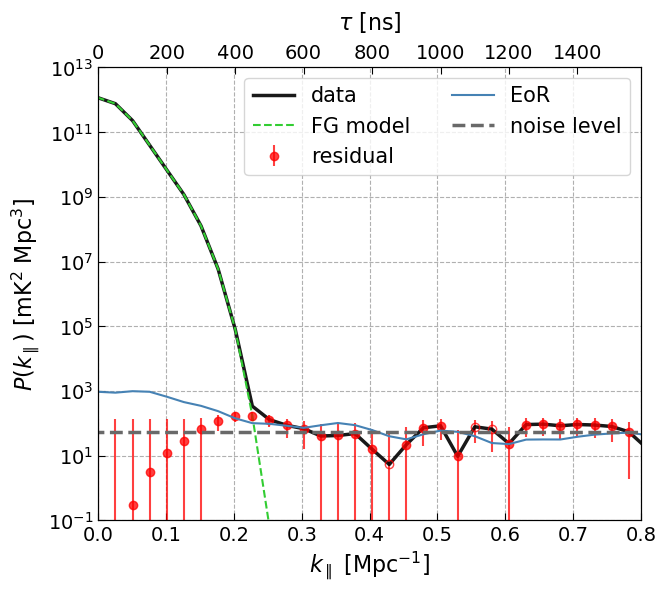

In [1511]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
ax.tick_params(labelsize=14, direction='in', size=5)
kpara = dlys * t2k
k = (0, 1, 'xx')

yerr = np.sqrt(D.pcov[k].diagonal())
gp_utils.plot_pspec(kpara, D.dpsp[k][0].real, ax, c='k', label='data', lw=2.5, comp='abs-real', alpha=0.9)
gp_utils.plot_pspec(kpara, F.mpsp[k][0].real, ax, c='limegreen', label='FG model', ls='--', lw=1.5, comp='abs')
gp_utils.plot_pspec(kpara, D.rpsp[k][0].real, ax, c='r', label='residual', ls='', fmt='o', yerr=yerr, alpha=0.75, comp='real')
gp_utils.plot_pspec(kpara, E.dpsp[k][0].real, ax, c='steelblue', label='EoR', lw=1.5, comp='real')
gp_utils.plot_pspec(kpara, np.sqrt(N.pcov[k].diagonal()), ax, c='dimgray', label='noise level', lw=2.5, ls='--')
#gp_utils.plot_pspec(kpara, E.mpsp[k][0].real, ax, c='darkblue', label='EoR Model', lw=1.5, comp='abs-real')
#gp_utils.plot_pspec(kpara, N.dpsp[k][0].real, ax, c='magenta', label='noise', ls='-', comp='real')
#ax.annotate(s='', xy=(0.01, 1e0), xytext=(0.01, 1e2), arrowprops=dict(arrowstyle='<|-|>'))
    
ax.set_xlabel(r'$k_\parallel$ [Mpc$^{-1}$]', fontsize=16)
ax.set_ylabel(r'$P(k_\parallel)$ [mK$^2$ Mpc$^{3}$]', fontsize=16)
ax.legend(fontsize=15, ncol=2)
ax.set_yscale('log')
ax.grid(ls='--')
ax.set_xlim(0, .8)
ax.set_ylim(1e-1, 1e13)
ax2 = ax.twiny()
ax2.set_xlim(np.array(ax.get_xlim())/t2k)
ax2.tick_params(labelsize=14, direction='in', size=5)
ax2.set_xlabel(r'$\tau$ [ns]', fontsize=16, labelpad=10)

In [1713]:
# calculate scalar
b = hp.PSpecBeamUV(beam)
scalar = b.compute_pspec_scalar(freqs[0,0]*1e6, freqs[-1,0]*1e6, len(freqs[:, 0]), taper='bh7')

In [268]:
# setup pspec
k = (0, 2, 'xx')
Kf = G.kernel_.get_params()[Knames[-1]].clone_with_theta(theta_ml[k][3:5])
Ke = G.kernel_.get_params()[Knames[-2]].clone_with_theta(theta_ml[k][1:3])
Kfp = [gp_utils.cov2pspec(Kf(freqs), scalar, 'bh7')]
Kep = [gp_utils.cov2pspec(Ke(freqs), scalar, 'bh7')]

# resample from posterior
ch = theta_chain[k]
rands = np.random.choice(np.arange(len(ch)), size=500, replace=False)
for i in rands:
    _Kf = Kf.clone_with_theta(np.log(ch[i, 2:]))
    _Ke = Ke.clone_with_theta(np.log(ch[i, :2]))
    Kfp.append(gp_utils.cov2pspec(_Kf(freqs), scalar, 'bh7'))
    Kep.append(gp_utils.cov2pspec(_Ke(freqs), scalar, 'bh7'))

Kfp, Kep = np.array(Kfp), np.array(Kep)

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


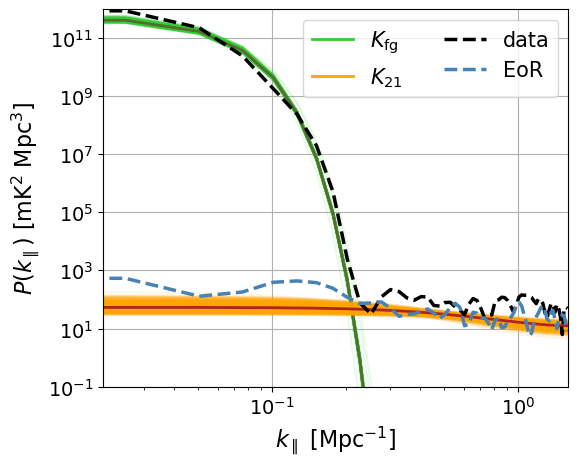

In [270]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
k = (0, 2, 'xx')

ax.plot(kpara, np.abs(Kfp)[::1].T, color='limegreen', lw=1.5, alpha=0.1)
ax.plot(kpara, np.abs(Kfp)[0], color='darkolivegreen', lw=2)
ax.plot(kpara, np.abs(Kep)[::1].T, color='orange', lw=1.5, alpha=0.1)
ax.plot(kpara, np.abs(Kep)[0], color='firebrick', lw=2)
p3 = ax.plot(kpara, np.abs(D.dpsp[k][0]), ls='--', c='k', lw=2.5)
p4 = ax.plot(kpara, E.dpsp[k][0].real, ls='--', color='steelblue', lw=2.5)
p1 = plt.Line2D([0], [0], color='limegreen', lw=2)
p2 = plt.Line2D([0], [0], color='orange', lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 1.6)
ax.set_ylim(1e-1, 1e12)
ax.tick_params(labelsize=14)
ax.grid()
ax.set_xlabel(r'$k_\parallel$ [Mpc$^{-1}$]', fontsize=16)
ax.set_ylabel(r'$P(k_\parallel)$ [mK$^2$ Mpc$^{3}$]', fontsize=16)
ax.legend([p1,p2,p3[0],p4[0]], [r'$K_{\rm fg}$', r'$K_{\rm 21}$', 'data', 'EoR'], fontsize=15, loc=1, ncol=2)

In [1795]:
imp.reload(qe)

<module 'pspec_qe' from '/lustre/aoc/projects/hera/nkern/gpr_errs_21cm/notebooks/pspec_qe.py'>

In [1787]:
ecov = np.cov(e.hd.data_array.squeeze().T)

In [1796]:
E.mdl_cov[k]=ecov

In [1797]:
E.mpsp, E.pcov, dlys = qe.qe(E.mdl, E.freqs, window=win, beam=beam, el=el, eh=eh,
                             cross=cross, cov=E.mdl_cov, blavg=blavg)

In [1792]:
Nfreqs = 128
Q = np.fft.ifft(np.eye(Nfreqs), axis=1)
pcov = np.zeros((Nfreqs, Nfreqs), np.complex)
for i in range(Nfreqs):
    for j in range(Nfreqs):
        Qa = Q[i][:, None].dot(Q[i][:, None].T.conj())
        Qb = Q[j][:, None].dot(Q[j][:, None].T.conj())
        pcov[i, j] = 2 * np.trace(Qa.dot(ecov).dot(Qb).dot(ecov))


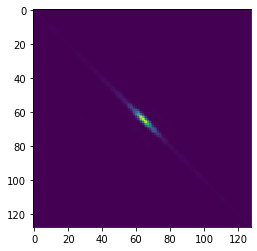

In [1799]:
plt.imshow(np.abs(E.pcov[k]))

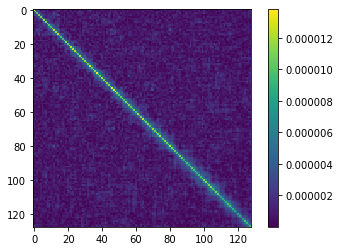

In [1804]:
plt.imshow(np.abs(ecov))
plt.colorbar()

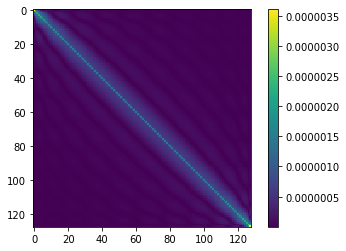

In [1807]:
plt.imshow(np.abs(E.mdl_cov[(0,1,'xx')]))
plt.colorbar()

Text(0.7, 0.9, '${\\rm Cov}[p_\\hat{f}]$')

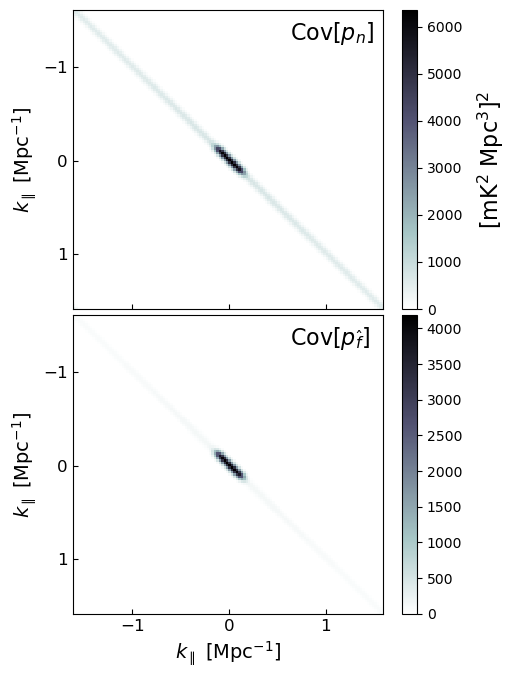

In [1735]:
fig, axes = plt.subplots(2, 1, figsize=(5, 8), dpi=100)
fig.subplots_adjust(hspace=0.02)
k = (0, 2, 'xx')

ax = axes[0]
ax.tick_params(labelsize=12, direction='in')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_xticklabels([])
cax = ax.imshow(N.pcov[k].real, aspect='auto', cmap='bone_r',
                extent=[kpara[0], kpara[-1], kpara[-1], kpara[0]])
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r'[mK$^2$ Mpc$^{3}$]$^2$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$k_\parallel$ [Mpc$^{-1}$]', fontsize=14)
ax.text(0.7, 0.90, r'${\rm Cov}[p_n]$', fontsize=16, transform=ax.transAxes)

ax = axes[1]
ax.tick_params(labelsize=12, direction='in')
ax.set_xticks([-1, 0, 1]); ax.set_yticks([-1, 0, 1])
cax = ax.imshow(E.pcov[k].real, aspect='auto', cmap='bone_r',
                extent=[kpara[0], kpara[-1], kpara[-1], kpara[0]])
cbar = fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$k_\parallel$ [Mpc$^{-1}$]', fontsize=14)
ax.set_ylabel(r'$k_\parallel$ [Mpc$^{-1}$]', fontsize=14)
ax.text(0.7, 0.90, r'${\rm Cov}[p_\hat{f}]$', fontsize=16, transform=ax.transAxes)

In [10]:
# load and setup
bls = [(0, 1), (0, 2), (0, 11), (0, 12), (0, 13), (0, 14), (0, 23), (0, 24), (0, 25), (0, 26)]
fgfile1 = '../data/gsm_sim_NSIDE256.uvh5'
eorfile1 = '../data/eor_sim_21cmFAST_default_NSIDE256.uvh5'
eorfile2 = '../data/eor_sim_21cmFAST_default_NSIDE256_run3.uvh5'
nfile = '../data/noise001_sim.uvh5'
times = np.arange(100)
covs = []
for ef in [eorfile1, eorfile2]:
    _, _, e, _ = sim_utils.setup_data(fgfile1, ef, nfile, times=times, bls=bls)
    covs.append(gp_utils.get_cov(e.hd.data_array.squeeze().T[:64]))
    covs.append(gp_utils.get_cov(e.hd.data_array.squeeze().T[64:]))

dnu = (D.freqs[:64] - D.freqs[0]) / 1e6
z1, z2 = C.f2z(np.mean(freqs[:64])*1e6), C.f2z(np.mean(freqs[64:])*1e6)

Text(0, 0.5, 'Normalized Covariance')

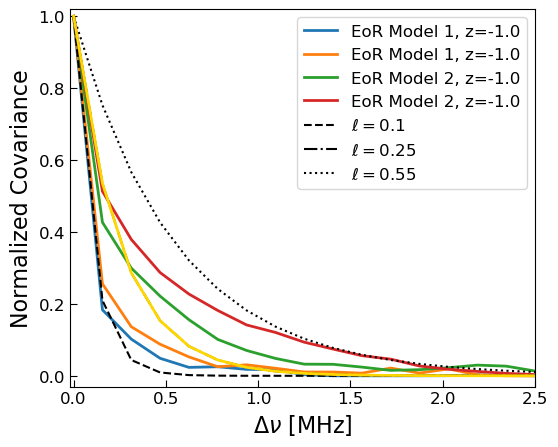

In [217]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.tick_params(labelsize=12, direction='in', size=5)

ax.plot(dnu, covs[0], lw=2, label='EoR Model 1, z={:.1f}'.format(z1))
ax.plot(dnu, covs[1], lw=2, label='EoR Model 1, z={:.1f}'.format(z2))
ax.plot(dnu, covs[2], lw=2, label='EoR Model 2, z={:.1f}'.format(z1))
ax.plot(dnu, covs[3], lw=2, label='EoR Model 2, z={:.1f}'.format(z2))

#ax.plot(dnu, np.exp(-dnu/0.25), c='k', ls='--', label=r'$\ell=0.25$')
#ax.plot(dnu, np.exp(-dnu/0.75), c='k', ls='-.', label=r'$\ell=0.75$')
#ax.plot(dnu, np.exp(-dnu/1.25), c='k', ls=':', label=r'$\ell=1.25$')

ax.plot(dnu, gp.kernels.Matern(nu=0.5, length_scale=0.1)(freqs[:64], freqs[:1]), c='k', ls='--', label=r'$\ell=0.1$')
ax.plot(dnu, gp.kernels.Matern(nu=0.5, length_scale=0.25)(freqs[:64], freqs[:1]), c='k', ls='-.', label=r'$\ell=0.25$')
ax.plot(dnu, gp.kernels.Matern(nu=0.5, length_scale=0.55)(freqs[:64], freqs[:1]), c='k', ls=':', label=r'$\ell=0.55$')

s = 1
y = stats.burr12.pdf(dnu, 1, 5, loc=0, scale=s)
y = stats.expon.pdf(dnu, loc=0, scale=.5)**2

ax.plot(dnu, y/y.max(), c='gold', lw=2)

#ax.set_yscale('log')
ax.set_xlim(-.02, 2.5)
ax.set_ylim(-3e-2, 1.02)
ax.legend(fontsize=12, ncol=1)
ax.set_xlabel(r'$\Delta\nu$ [MHz]', fontsize=16)
ax.set_ylabel('Normalized Covariance', fontsize=16)